# **TRABAJO PRÁCTICO - FUNDAMENTOS DE LA CIENCIA DE DATOS**


# **Descripción del dataset elegido**

El dataset contiene más de 20.000 partidas de ajedrez de Lichess.org.

Las variables que contiene son las siguientes:

    
*   **Game ID:** ID de la partida
*   **Rated (T/F):**  booleano que indica si el jugador está rankeado o no
*   **Start Time:** Tiempo de inicio
*   **End Time:** Tiempo de finalización
*   **Number of Turns:** Número de movimientos
*   **Game Status:** Resultado de la partida (Puede tomar los valores: outoftime, resign, mate or draw)
*   **Winner:** Ganador (blancas/negras)
*   **Time Increment:** Código de incremento
*   **White Player ID:** ID blancas
*   **White Player Rating:** Puntaje blancas
*   **Black Player ID:** ID negras
*   **Black Player Rating:** Puntaje negras
*   **All Moves in Standard Chess Notation:** Todos los movimientos en la notación estándar de ajedrez
*   **Opening Eco:** Código estandarizado para cada apertura
*   **Opening Name:** Nombre de la apertura
*   **Opening Ply:** Cantidad de movimientos en la fase de apertura





# **Manipulación y transformación del dataset**

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib.lines import Line2D

In [18]:
# Importamos el dataset con Pandas
games = pd.read_csv("games.csv", header=0)
games.reset_index(drop=True, inplace=True)

# Eliminamos columnas redundantes o que no aportan al análisis
games = games.drop(['id', 'created_at', 'last_move_at', 'opening_eco'], axis=1)

# Renombramos las columnas para mayor comodidad
games = games.rename(columns={'rated': 'Rankeado (V/F)',
                              'turns': 'Movimientos (Cantidad)',
                              'victory_status': 'Resultado',
                              'winner': 'Ganador',
                              'white_id': 'ID Blancas',
                              'white_rating': 'Puntaje Blancas',
                              'black_id': 'ID Negras',
                              'black_rating': 'Puntaje Negras',
                              'increment_code': 'Código de Incremento',
                              'moves': 'Jugadas',
                              'opening_name': 'Apertura',
                              'opening_ply': 'Puntaje Blancas',
                              'white_rating': 'Puntaje Blancas',
                              'opening_ply': 'Cantidad de movimientos en la apertura'})


A continuación, vamos a echar un vistazo a la columna 'Código de Incremento'.

Esta columna tiene algunos problemas que habrá que resolver.

Por un lado, podemos notar que el primer número que lo conforma, indica al tiempo que tiene el jugador para realizar movimientos. El segundo número se refiere a los segundos de incremento que obtiene en cada jugada. Para facilitar el análisis, sería mejor separar estos dos números en diferentes columnas y, así, poder utilizarlos como números, en lugar de un "código" que representa dos cuestiones diferentes.

Por otro lado, podemos ver que hay 400 tipos diferentes de 'Código de Incremento', es decir, de formatos de juego. Analizar cada uno de ellos resultaría complicado. Para solucionar este problema, vamos a agregar una nueva columna que llamaremos 'Formato de Juego' donde se guardará la clasificación del juego según el tiempo disponible por cada jugador. Esta columna tendrá cuatro valores posibles de tipo string: Bullet, Blitz, Rápido, Clásico.

Bullet serán aquellas partidas que tengan el tiempo de inicio menor o igual a 3 minutos, Blitz entre 3 y 10, los 15 minutos estarán bajo la categoría de Rápido. Las partidas estándar o ajedrez clásico son también llamadas partidas de ajedrez normal o lento, en las que cada jugador tiene un tiempo de a lo sumo media hora.


In [19]:
len(games['Código de Incremento'].unique()) # Hay 400 "códigos de incremento" distintos

400

In [20]:
# Separamos la columna "increment_code" en "Duración Partida" y "Incremento por Jugada"
games[['Tiempo Partida', 'Incremento por Jugada']] = games['Código de Incremento'].str.split('+', expand=True)

# Convertimos las nuevas columnas a números enteros
games['Tiempo Partida'] = pd.to_numeric(games['Tiempo Partida'])
games['Incremento por Jugada'] = pd.to_numeric(games['Incremento por Jugada'])

In [21]:
# Definimos una función para separar en categorias las partidas según el tiempo disponible por cada jugador

def game_format(time):

    if time <= 3:
        return 'Bullet'
    elif time <= 10:
        return 'Blitz'
    elif time <= 60:
        return 'Rapido'
    else:
        return 'Clasico'

#Creamos una columna para esta clasificación
games['Formato de juego'] = np.vectorize(game_format)(games['Tiempo Partida'])

EL mismo problema que sucedía con la columna "Código de Incremento" lo encontramos con la columna "Aperturas", encontrando 1477 variantes diferentes de aperturas en todo el datastet. ¡Esto es casi una apertura diferente por cada catorce partidas!
Decidimos entonces crear una nueva columna "Apertura Principal" que extrae de la columna "Aperturas", justamente, su apertura principal. Observamos que había cientos de aperturas que solo se jugaron una vez, todas estas las incluímos en la categoría de "Other" (otras) dentro de la columna de "Apertura Principal".

In [22]:
len(games['Apertura'].unique())

1477

In [23]:
games['Apertura'] = games['Apertura'].fillna("Desconocida")

In [24]:
def categorizar_apertura(apertura):
    if re.search(r'.*Sicilian Defense', apertura, re.IGNORECASE):
        return 'Sicilian'
    elif re.search(r'.*Ruy Lopez', apertura, re.IGNORECASE):
        return 'Ruy Lopez'
    elif re.search(r'.*Italian Game', apertura, re.IGNORECASE):
        return 'Italian'
    elif re.search(r'.*French Defense', apertura, re.IGNORECASE):
        return 'French'
    elif re.search(r'.*Slav Defense', apertura, re.IGNORECASE):
        return 'Slav'
    elif re.search(r'.*Nimzowitsch', apertura, re.IGNORECASE):
        return 'Nimzowitsch'
    elif re.search(r".*Queen's Pawn", apertura, re.IGNORECASE):
        return "Queen's Pawn"
    elif re.search(r'.*Philidor Defense', apertura, re.IGNORECASE):
        return 'Philidor'
    elif re.search(r'.*Blackmar-Diemer Gambit', apertura, re.IGNORECASE):
        return 'Blackmar-Diemer Gambit'
    elif re.search(r'.*Scandinavian Defense', apertura, re.IGNORECASE):
        return 'Scandinavian'
    elif re.search(r'.*Four Knights Game', apertura, re.IGNORECASE):
        return 'Four Knights'
    elif re.search(r'.*Horwitz Defense', apertura, re.IGNORECASE):
        return 'Horwitz'
    elif re.search(r'.*English Opening', apertura, re.IGNORECASE):
        return 'English'
    elif re.search(r".*Scotch Game", apertura, re.IGNORECASE):
        return "Scotch"
    elif re.search(r'.*Marshall Defense', apertura, re.IGNORECASE):
        return 'Marshall'
    elif re.search(r".*Queen's Gambit", apertura, re.IGNORECASE):
        return "Queen's Gambit"
    elif re.search(r'.*Modern', apertura, re.IGNORECASE):
        return 'Modern'
    elif re.search(r'.*Blackmar-Diemer Gambit', apertura, re.IGNORECASE):
        return 'Blackmar-Diemer Gambit'
    elif re.search(r'.*Indian Game', apertura, re.IGNORECASE):
        return 'Indian'
    elif re.search(r".*King's Pawn Game", apertura, re.IGNORECASE):
        return "King's Pawn Game"
    elif re.search(r".*Dutch Defense", apertura, re.IGNORECASE):
        return "Dutch"
    elif re.search(r'.*Zukertort Opening', apertura, re.IGNORECASE):
        return 'Zukertort'
    elif re.search(r'.*Vienna Game', apertura, re.IGNORECASE):
        return 'Vienna'
    elif re.search(r'.*Blumenfeld Countergambit', apertura, re.IGNORECASE):
        return 'Blumenfeld Countergambit'
    elif re.search(r'C.*rab Opening', apertura, re.IGNORECASE):
        return 'Crab'
    elif re.search(r".*Queen's Indian Defense", apertura, re.IGNORECASE):
        return "Queen's Indian"
    elif re.search(r'.*Gruenfeld Defense', apertura, re.IGNORECASE):
        return 'Gruenfeld'
    elif re.search(r".*Yusupov-Rubinstein", apertura, re.IGNORECASE):
        return "Yusupov-Rubinstein"
    elif re.search(r".*Bishop's Opening", apertura, re.IGNORECASE):
        return "Bishop's"
    elif re.search(r'.*Benoni Defense', apertura, re.IGNORECASE):
        return 'Benoni'
    elif re.search(r".*King's Indian Attack", apertura, re.IGNORECASE):
        return "King's Indian"
    elif re.search(r'.*Alekhine Defense ', apertura, re.IGNORECASE):
        return 'Alekhine'
    elif re.search(r'.*Caro-Kann Defense', apertura, re.IGNORECASE):
        return 'Caro-Kann'
    elif re.search(r'.*Goldsmith Defense', apertura, re.IGNORECASE):
        return 'Goldsmith'
    elif re.search(r".*Nimzo-Indian Defense", apertura, re.IGNORECASE):
        return "Nimzo-Indian"
    elif re.search(r'.*Bogo-Indian Defense', apertura, re.IGNORECASE):
        return 'Bogo-Indian'
    elif re.search(r".*King's Knight Opening", apertura, re.IGNORECASE):
        return "King's Knight"
    elif re.search(r'.*Amar Opening', apertura, re.IGNORECASE):
        return 'Amar'
    elif re.search(r'.*Paleface Attack', apertura, re.IGNORECASE):
        return 'Paleface Attack'
    elif re.search(r'.*Hungarian Opening', apertura, re.IGNORECASE):
        return 'Hungarian'
    elif re.search(r'.*Center Game', apertura, re.IGNORECASE):
        return 'Center'
    elif re.search(r".*Englund Gambit", apertura, re.IGNORECASE):
        return "Englund Gambit"
    elif re.search(r'.*Giuoco Piano', apertura, re.IGNORECASE):
        return 'Italian'
    elif re.search(r".*Petrov's Defense", apertura, re.IGNORECASE):
        return "Petrov's"
    elif re.search(r'.*Russian Game', apertura, re.IGNORECASE):
        return 'Russian'
    elif re.search(r'.*Pirc Defense', apertura, re.IGNORECASE):
        return 'Pirc'
    elif re.search(r'.*St. George Defense', apertura, re.IGNORECASE):
        return 'St. George'
    elif re.search(r".*Bird Opening", apertura, re.IGNORECASE):
        return "Bird"
    elif re.search(r".*Owen Defense", apertura, re.IGNORECASE):
        return "Owen"
    elif re.search(r'.*Semi-Slav Defense', apertura, re.IGNORECASE):
        return 'Semi-Slav'
    elif re.search(r'.*Polish Opening', apertura, re.IGNORECASE):
        return 'Polish'
    elif re.search(r'.*Ponziani Opening', apertura, re.IGNORECASE):
        return 'Ponziani'
    elif re.search(r'.*East Indian Defense', apertura, re.IGNORECASE):
        return 'East Indian'
    elif re.search(r".*Reti Opening", apertura, re.IGNORECASE):
        return "Reti"
    elif re.search(r'.*Nimzo-Larsen Attack', apertura, re.IGNORECASE):
        return 'Nimzo-Larsen Attack'
    elif re.search(r".*Torre Attack", apertura, re.IGNORECASE):
        return "Torre Attack"
    elif re.search(r".*Creepy Crawly Formation", apertura, re.IGNORECASE):
        return "Creepy Crawly Formation"
    elif re.search(r".*Elephant Gambit", apertura, re.IGNORECASE):
        return "Elephant Gambit"
    elif re.search(r".*Latvian Gambit", apertura, re.IGNORECASE):
        return "Latvian Gambit"
    elif re.search(r".*Global Opening", apertura, re.IGNORECASE):
        return "Global Opening"
    elif re.search(r".*Trompowsky Attack", apertura, re.IGNORECASE):
        return "Trompowsky Attack"
    elif re.search(r".*London System", apertura, re.IGNORECASE):
        return "London System"
    elif re.search(r".*Danish Gambit", apertura, re.IGNORECASE):
        return "Danish Gambit"
    elif re.search(r".*Mieses", apertura, re.IGNORECASE):
        return "Mieses"
    elif re.search(r".*Carr Defense", apertura, re.IGNORECASE):
        return "Carr"
    elif re.search(r".*Three Knights Opening", apertura, re.IGNORECASE):
        return "Three Knights"
    elif re.search(r".*Ware Opening", apertura, re.IGNORECASE):
        return "Ware"
    elif re.search(r".*Budapest Defense", apertura, re.IGNORECASE):
        return "Budapest"
    elif re.search(r".*Richter-Veresov Attack", apertura, re.IGNORECASE):
        return "Richter-Veresov Attack"
    elif re.search(r".*Van Geet Opening", apertura, re.IGNORECASE):
        return "Van Geet"
    elif re.search(r".*Kadas Opening", apertura, re.IGNORECASE):
        return "Kadas"
    elif re.search(r".*System", apertura, re.IGNORECASE):
        return "System"
    elif re.search(r".*Rat Defense", apertura, re.IGNORECASE):
        return "Rat"
    elif re.search(r".*Gedult's Opening", apertura, re.IGNORECASE):
        return "Gedult's"
    elif re.search(r".*Colle System", apertura, re.IGNORECASE):
        return "Colle System"
    elif re.search(r".*Grob Opening", apertura, re.IGNORECASE):
        return "Grob"
    elif re.search(r".*Mikenas Defense", apertura, re.IGNORECASE):
        return "Mikenas"
    elif re.search(r".*Tarrasch Defense", apertura, re.IGNORECASE):
        return "Tarrasch"
    elif re.search(r".*Anderssen Opening", apertura, re.IGNORECASE):
        return "Anderssen"
    elif re.search(r".*Portuguese Opening", apertura, re.IGNORECASE):
        return "Portuguese"
    elif re.search(r".*Irish Gambit", apertura, re.IGNORECASE):
        return "Irish Gambit"
    elif re.search(r".*Clemenz Opening", apertura, re.IGNORECASE):
        return "Clemenz"
    elif re.search(r".*Mexican Defense", apertura, re.IGNORECASE):
        return "Mexican"
    elif re.search(r".*Barnes Defense", apertura, re.IGNORECASE):
        return "Barnes"
    else:
        return 'Other'

# Aplicamos la función a la columna 'Apertura'
games['Apertura Principal'] = games['Apertura'].apply(categorizar_apertura)

# Contamos la cantidad de partidas por cada apertura principal
print(games['Apertura Principal'].value_counts())

Apertura Principal
Sicilian                   2650
French                     1412
Queen's Pawn               1358
Other                      1311
Italian                    1089
                           ... 
Carr                          5
Creepy Crawly Formation       5
Alekhine                      4
Irish Gambit                  3
Global Opening                1
Name: count, Length: 81, dtype: int64


Decidimos eliminar del dataset las 1311 partidas cuya apertura principal cae en la categoría "residual" de "Other" ya que entorpecen el análisis posterior y solo representan un ~6.5% del total de partidas.

In [25]:
# Eliminamos registros donde "Apertura Principal" es "Other"
games = games[games["Apertura Principal"] != "Other"]

# Reseteamos el índice después de eliminar los registros
games.reset_index(drop=True, inplace=True)

# Contamos la cantidad de partidas por cada apertura principal luego de eliminar la categoría residual
print(games['Apertura Principal'].value_counts())

# Verificamos el resultado
games['Apertura Principal']

Apertura Principal
Sicilian                   2650
French                     1412
Queen's Pawn               1358
Italian                    1089
King's Pawn Game            881
                           ... 
Carr                          5
Creepy Crawly Formation       5
Alekhine                      4
Irish Gambit                  3
Global Opening                1
Name: count, Length: 80, dtype: int64


,Apertura Principal
0,Slav
1,Nimzowitsch
2,King's Pawn Game
3,Queen's Pawn
4,Philidor
...,...
18742,Dutch
18743,Queen's Pawn
18744,Queen's Pawn
18745,Pirc


In [26]:
# Mostramos el DataFrame modificado
games.head()

,Rankeado (V/F),Movimientos (Cantidad),Resultado,Ganador,Código de Incremento,ID Blancas,Puntaje Blancas,ID Negras,Puntaje Negras,Jugadas,Apertura,Cantidad de movimientos en la apertura,Tiempo Partida,Incremento por Jugada,Formato de juego,Apertura Principal
0,False,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,Slav Defense: Exchange Variation,5,15,2,Rapido,Slav
1,True,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,Nimzowitsch Defense: Kennedy Variation,4,5,10,Blitz,Nimzowitsch
2,True,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,King's Pawn Game: Leonardis Variation,3,5,10,Blitz,King's Pawn Game
3,True,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,Queen's Pawn Game: Zukertort Variation,3,20,0,Rapido,Queen's Pawn
4,True,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,Philidor Defense,5,30,3,Rapido,Philidor


Realizamos una mirada general de nuestro dataset.

Mediante el metodo info(), notamos que tenemos datos de tipo booleano, entero, y object que representa a los datos de tipo string de nuestro dataset. Estos tipo de de datos son los esperados para cada variable.

Además, observamos que hay 16 columnas y 18746 filas, las cuales no poseen valores nulos.

In [27]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18747 entries, 0 to 18746
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Rankeado (V/F)                          18747 non-null  bool  
 1   Movimientos (Cantidad)                  18747 non-null  int64 
 2   Resultado                               18747 non-null  object
 3   Ganador                                 18747 non-null  object
 4   Código de Incremento                    18747 non-null  object
 5   ID Blancas                              18747 non-null  object
 6   Puntaje Blancas                         18747 non-null  int64 
 7   ID Negras                               18747 non-null  object
 8   Puntaje Negras                          18747 non-null  int64 
 9   Jugadas                                 18747 non-null  object
 10  Apertura                                18747 non-null  object
 11  Ca

In [28]:
games.isnull().sum()

,0
Rankeado (V/F),0
Movimientos (Cantidad),0
Resultado,0
Ganador,0
Código de Incremento,0
ID Blancas,0
Puntaje Blancas,0
ID Negras,0
Puntaje Negras,0
Jugadas,0


In [29]:
games.isna().sum()

,0
Rankeado (V/F),0
Movimientos (Cantidad),0
Resultado,0
Ganador,0
Código de Incremento,0
ID Blancas,0
Puntaje Blancas,0
ID Negras,0
Puntaje Negras,0
Jugadas,0


# **Análisis exploratorio de los datos**

En esta etapa realizaremos un análisis exploratorio de los datos mediante el calculo de las medidas descriptivas y ayudandonos de diferentes
herramientas de visualización.

## Jugadores Rankeados

Primero, quisimos conocer la proporción de jugadores que tienen puntaje, respecto de los que no.

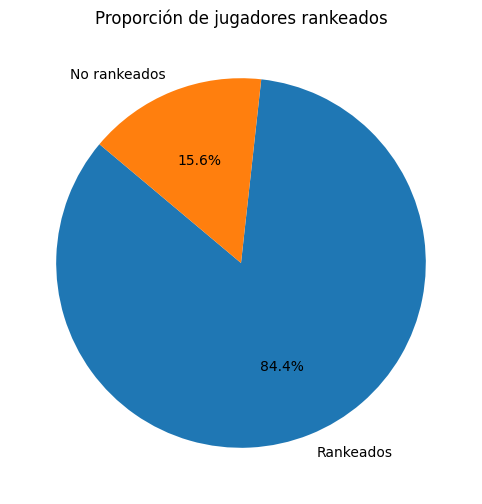

In [30]:
# Combinamos las columnas 'ID Blancas' y 'ID Negras' en una lista de jugadores únicos para evitar que la repetición de jugadores influya en el resultado
jugadores_blancas = games['ID Blancas'].astype(str)
jugadores_negras = games['ID Negras'].astype(str)
todos_jugadores = pd.concat([jugadores_blancas, jugadores_negras]).unique()

# Contamos si cada jugador está rankeado o no
rankeados = games.loc[(games['Rankeado (V/F)'] == True), 'ID Blancas'].astype(str)
rankeados = pd.concat([rankeados, games.loc[(games['Rankeado (V/F)'] == True), 'ID Negras'].astype(str)])
rankeados = rankeados.unique()

# Contamos los jugadores no rankeados
no_rankeados = len(todos_jugadores) - len(rankeados)

# Graficamos el gráfico de tortas
plt.figure(figsize=(8, 6))
plt.pie([len(rankeados), no_rankeados], labels=['Rankeados', 'No rankeados'], autopct='%1.1f%%', startangle=140)
plt.title('Proporción de jugadores rankeados')
plt.show()


Notamos que la gran mayoría de los jugadores, efectivamente, están rankeados.

## Cantidad de Movimientos y Formatos de Juego

Más aún, interesa analizar la proporción de partidas que corresponden a cada uno de los formatos de juego y ver cómo se relacionan con la cantidad de movimientos.

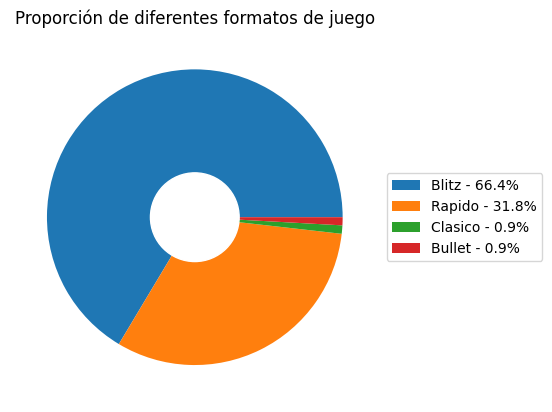

In [31]:
# Creamos un diccionario con los diferentes formatos de juegos y sus frecuencias.
category_counts = games['Formato de juego'].value_counts().to_dict()

# Creamos el círculo central del gráfico
my_circle = plt.Circle( (0,0), 0.3, color='white')

# Creamos el gráfico de dona
plt.pie(category_counts.values(), labels=None, autopct=None)
labels = ['{} - {:.1f}%'.format(k, v/sum(category_counts.values())*100) for k, v in category_counts.items()]
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Proporción de diferentes formatos de juego')

plt.show()

Observamos que las categorías "Clásico" y "Bullet" tienen una representación insignificante en comparación con las categorías "Rapido" y "Blitz". Esto puede deberse a que las partidas de larga duración como la modalidad "Clásico" no suelen darse en una aplicación móbil. Tales partidas siempre se celebran adecuadamente en el tablero físico. Por otro lado, respecto a las partidas "Bullet", sospechamos que son poco elegidas debido a su extremadamente corta duración.


Luego, deseamos obtener el promedio de cantidad de movimientos y analizar cómo se distribuye esta variable. Al visualizarlo en un Boxplot observamos una gran cantidad de outliers del lado derecho, es decir, la cantidad de movimientos de cada partida se comporta como una distribución asimétrica a la derecha con presencia de outliers hacía los valores mayores. Esto nos conduce a calcular también la mediana para obtener una medida más robusta, no tan influenciada por los valores atípicos.

Analizaremos también cómo se comporta esta variable según el formato de juego.

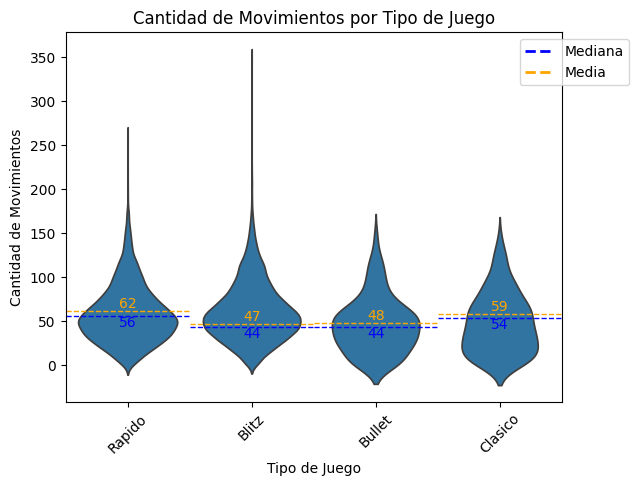

In [32]:
# Creamos el violin plot
sns.violinplot(x='Formato de juego', y='Movimientos (Cantidad)', data=games, inner=None)

# Obtener los valores de la media y la mediana por tipo de juego
medians = games.groupby('Formato de juego')['Movimientos (Cantidad)'].median()
means = games.groupby('Formato de juego')['Movimientos (Cantidad)'].mean()

# Agregar líneas para la mediana y la media en cada violin plot
for i, (label, median) in enumerate(medians.items()):
    plt.text(i, median, f'{median:.0f}', ha='center', va='top', color='blue')
    plt.text(i, means[label], f'{means[label]:.0f}', ha='center', va='bottom', color='orange')
    plt.axhline(median, color='blue', linestyle='--', linewidth=1, xmin=i/len(medians), xmax=(i+1)/len(medians))
    plt.axhline(means[label], color='orange', linestyle='--', linewidth=1, xmin=i/len(medians), xmax=(i+1)/len(medians))

# Configuración adicional
plt.title('Cantidad de Movimientos por Tipo de Juego')
plt.xlabel('Tipo de Juego')
plt.ylabel('Cantidad de Movimientos')
plt.xticks(rotation=45)  # Rotar etiquetas en el eje x si es necesario

# Agregar leyenda con los colores correspondientes
custom_lines = [Line2D([0], [0], color='blue', lw=2, linestyle='--'),
                Line2D([0], [0], color='orange', lw=2, linestyle='--')]
plt.legend(custom_lines, ['Mediana', 'Media'], loc='upper right', bbox_to_anchor=(1.15, 1))

# Mostrar el gráfico
plt.show()


Notamos que las categorías "Blitz" y "Rápido" tienen mayor presencia de outliers, pero eso puede deberse al hecho de que son formatos de juego con muchísima representación en nuestro dataset.

A su vez, la proporción de partidas "Bullet" y "Clásico" es insignificante por lo que realmente no se pueden sacar conclusiones muy rigurosas sobre estas categorías.

## Resultados de las partidas

Además, nos interesó conocer la frecuencia de cada resultado obtenido en las partidas.

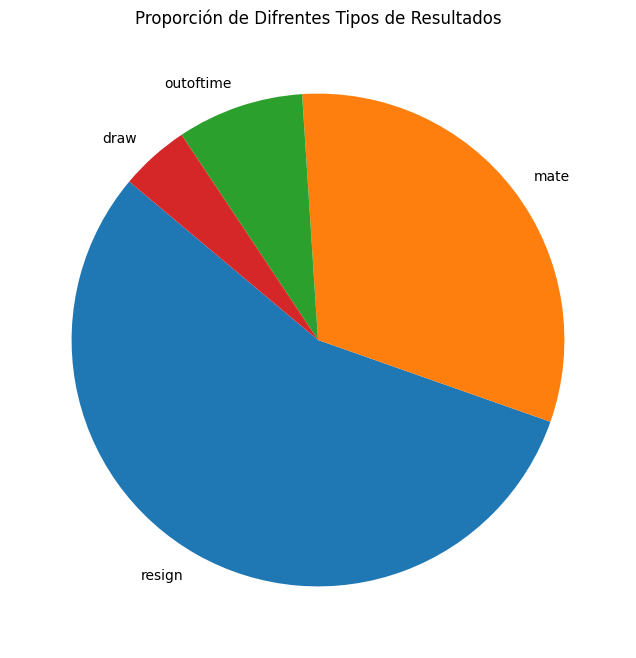

In [33]:
# Contamos las ocurrencias de cada resultado
resultado_counts = games['Resultado'].value_counts()

# Creamos el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(resultado_counts, labels=resultado_counts.index, startangle=140)
plt.title('Proporción de Difrentes Tipos de Resultados')
plt.show()

Vemos que la mayor parte de las partidas, 55.6%, terminan en "resign". Este es el caso en el que alguno de los jugadores renuncia a la partida.

Luego, la siguiente opcion mas probable es el "mate", lo que indica que hay un ganador y un perdedor.

Los resultados menos frecuentes son empate ("draw") y que los jugadores se hayan quedado sin tiempo ("outoftime").

¿Alguno de estos tipos de resultados será mas freceunte para ciertos formatos de jugada?

<ipython-input-34-00e88e6198a3>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(x*100) for x in ax.get_xticks()])


Text(0.5, 1.0, 'Porcentaje de Resultados por Formato de Juego')

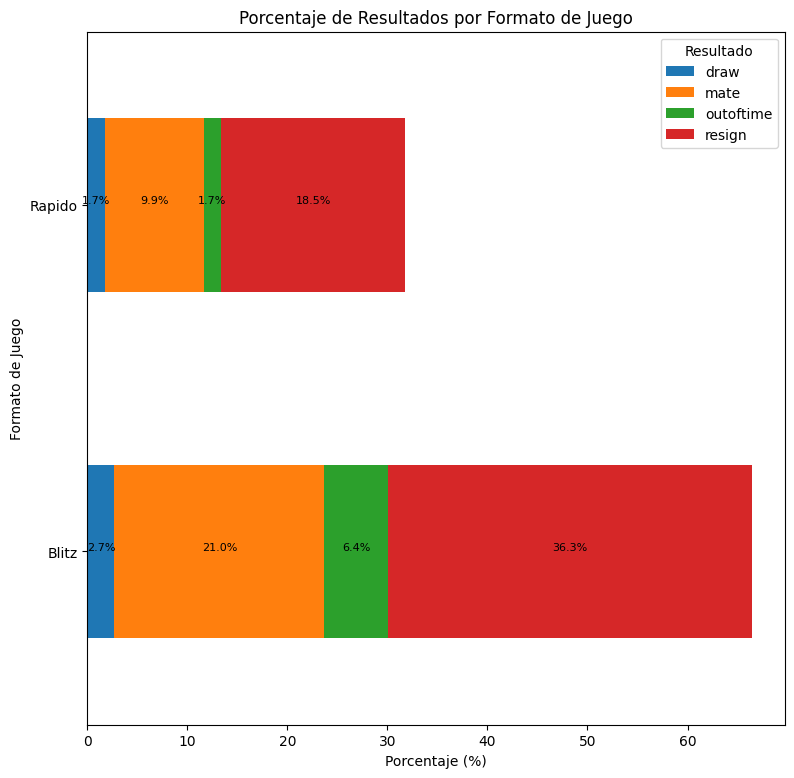

In [34]:
# Calcular porcentaje de cada formato de juego
format_pct = games['Formato de juego'].value_counts(normalize=True).sort_index()

# Calcular porcentaje de cada resultado para cada formato de juego
result_pct = games.groupby('Formato de juego')['Resultado'].value_counts(normalize=True).unstack().fillna(0)

# Crear DataFrame para los porcentajes de resultados por formato de juego
result_format_pct = result_pct.mul(format_pct, axis=0)

# Elimina los elementos de categorias "Bullet" y "Clasico", ya que sabemos que su proporción es no es significativa para este dataset
result_format_pct = result_format_pct.drop("Bullet")
result_format_pct = result_format_pct.drop("Clasico")

# Crear gráfico de barras apiladas
ax = result_format_pct.plot.barh(stacked=True, figsize=(9,9))

# Agregar etiquetas de porcentaje en cada subcategoría
for rect in ax.patches:
    # Obtener el ancho de la barra
    width = rect.get_width()
    # Calcular el porcentaje y convertirlo en un número entero
    percentage = width * 100
    # Agregar el porcentaje como etiqueta
    ax.annotate(f'{percentage:.1f}%',
                xy=(rect.get_x() + width / 2, rect.get_y() + rect.get_height() / 2),
                xytext=(0, 3),  # Desplazamiento de la etiqueta
                textcoords="offset points",
                ha='center', va='center',
                fontsize=8)  # Tamaño de la letra

# Establecer etiquetas y título
ax.set_xticklabels([int(x*100) for x in ax.get_xticks()])
ax.set_xlabel('Porcentaje (%)')
ax.set_ylabel('Formato de Juego')
ax.set_title('Porcentaje de Resultados por Formato de Juego')

Cabe aclarar que cada barra en el gráfico representará el 100% de la suma de los porcentajes para esa categoría de formato de juego. Cada segmento de la barra representará la proporción de cada subcategoría (Resultado) dentro de esa categoría (Formato de juego).

Luego, se puede ver que la mayoria de las partidas de la categoria "Rapido" terminaron en "resing", al igual que para la categoria "Blitz". Sin embargo, la categoria "Blitz" tiene una mayor proporción de resultados "outoftime" que la categoria "Rapido".

## Aperturas

A continuación, nos interesó observar la frecuencia de las aperturas más populares.


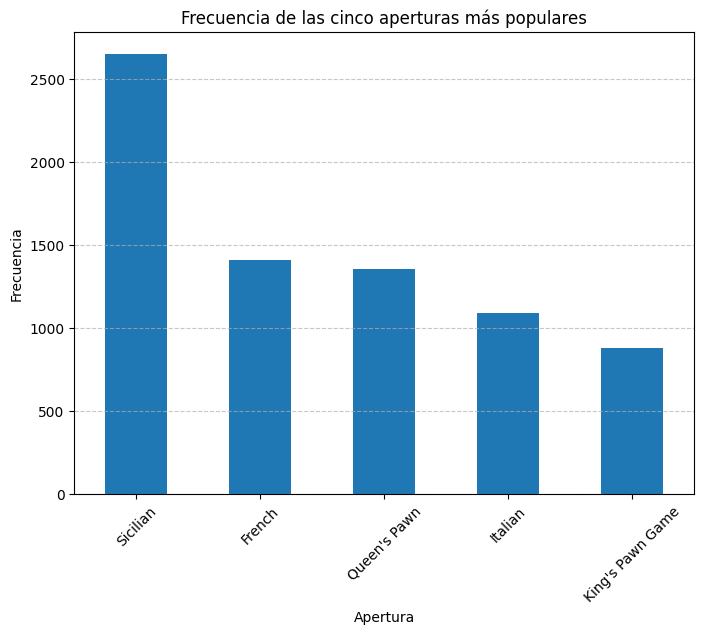

In [35]:
# Calculamos la frecuencia de cada apertura
frecuencia_aperturas = games['Apertura Principal'].value_counts()

# Seleccionamos las 5 aperturas más comunes
frecuencia_top_aperturas = frecuencia_aperturas.head(5)

# Graficamos el histograma de frecuencia de aperturas
plt.figure(figsize=(8, 6))
frecuencia_top_aperturas.plot(kind='bar')
plt.title('Frecuencia de las cinco aperturas más populares')
plt.xlabel('Apertura')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje x para una mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Además, quisimos observar las aperturas menos populares.


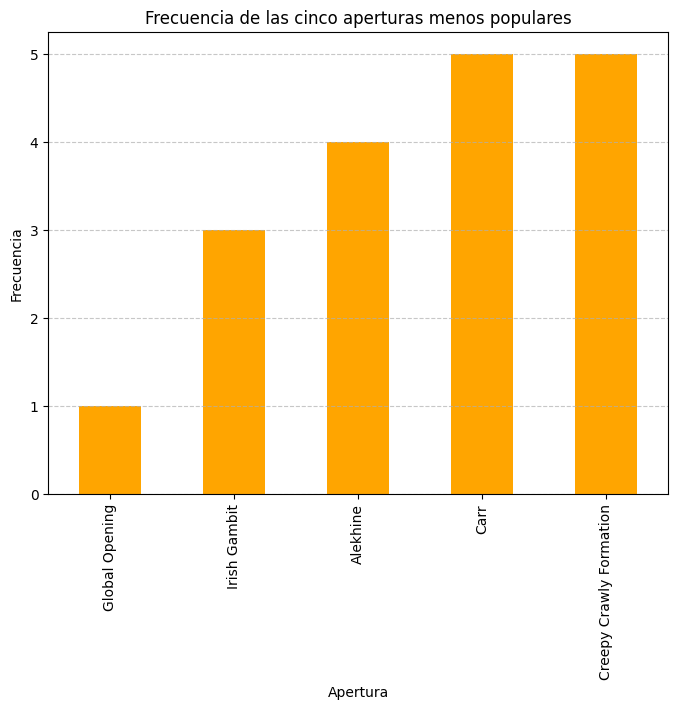

In [36]:
# Calculamos la frecuencia de cada apertura
frecuencia_aperturas = games['Apertura Principal'].value_counts()

# Seleccionamos los 5 valores menos frecuentes
frecuencia_aperturas = frecuencia_aperturas.nsmallest(5)

# Filtrar el DataFrame para incluir solo las filas con estos valores
filtered_df = games[games['Apertura'].isin(frecuencia_aperturas.index)]

# Graficamos el histograma de frecuencia de aperturas
plt.figure(figsize=(8, 6))
frecuencia_aperturas.plot(kind='bar', color='orange')
plt.title('Frecuencia de las cinco aperturas menos populares')
plt.xlabel('Apertura')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)  # Rotamos las etiquetas del eje x para una mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Puntajes

Por otro lado, la segunda apertura más frecuente, sí es bastante popular. Nuevamente graficamos el puntaje de los jugadores que propusieron dicha apertura (es decir, los que jugaron con negras en esas partidas) en contraste con el puntaje de los jugadores que jugaron con negras y eligieron otras aperturas. Más aún, indicamos el promedio de cada grupo buscando comparar los resultados con el ejemplo anterior.

<ipython-input-37-9b8f489e1660>:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_sicilian_defense, label="Sicilian Defense", shade=True, color='hotpink')
<ipython-input-37-9b8f489e1660>:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_otra_apertura, label="Otra Apertura", shade=True, color='#8A2BE2')


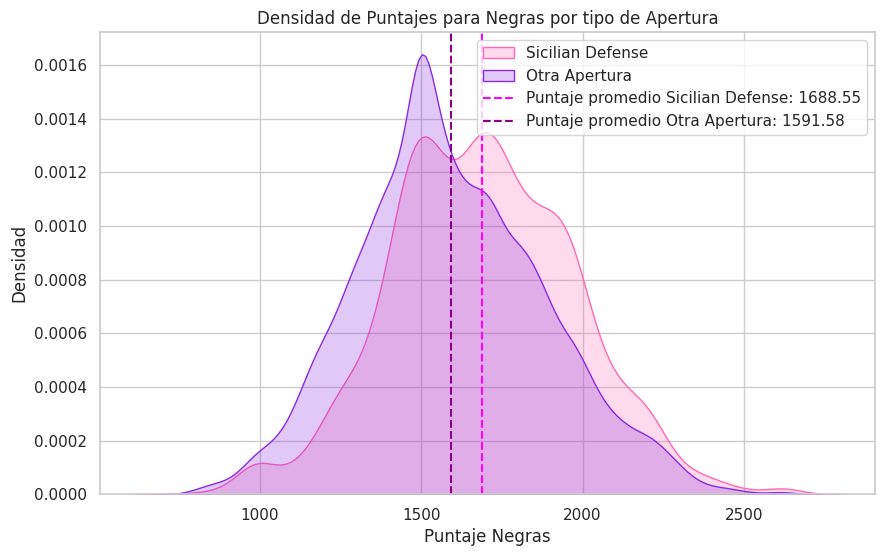

In [37]:
# Filtramos las filas por tipo de apertura
sicilian_defense = games[games['Apertura Principal'] == "Sicilian"]
otra_apertura = games[games['Apertura Principal'] != "Sicilian Defense"]

# Creamos dos subconjuntos de datos
data_sicilian_defense = sicilian_defense['Puntaje Negras']
data_otra_apertura = otra_apertura['Puntaje Negras']

# Trazamos los gráficos de densidad utilizando Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Calculamos el promedio y la mediana
mean_sicilian_defense = data_sicilian_defense.mean()
mean_otra_apertura = data_otra_apertura.mean()

# Graficamos los gráficos de densidad
sns.kdeplot(data=data_sicilian_defense, label="Sicilian Defense", shade=True, color='hotpink')
sns.kdeplot(data=data_otra_apertura, label="Otra Apertura", shade=True, color='#8A2BE2')

# Agregamos líneas verticales para promedio y mediana
plt.axvline(mean_sicilian_defense, color='fuchsia', linestyle='--', label=f"Puntaje promedio Sicilian Defense: {mean_sicilian_defense:.2f}")
plt.axvline(mean_otra_apertura, color='darkmagenta', linestyle='--', label=f"Puntaje promedio Otra Apertura: {mean_otra_apertura:.2f}")

plt.title("Densidad de Puntajes para Negras por tipo de Apertura")
plt.xlabel("Puntaje Negras")
plt.ylabel("Densidad")
plt.legend()
plt.show()

En este caso, notamos que el puntaje promedio de negras en partidas con otras aperturas es similar al puntaje usando Sicilian Defense como apertura.

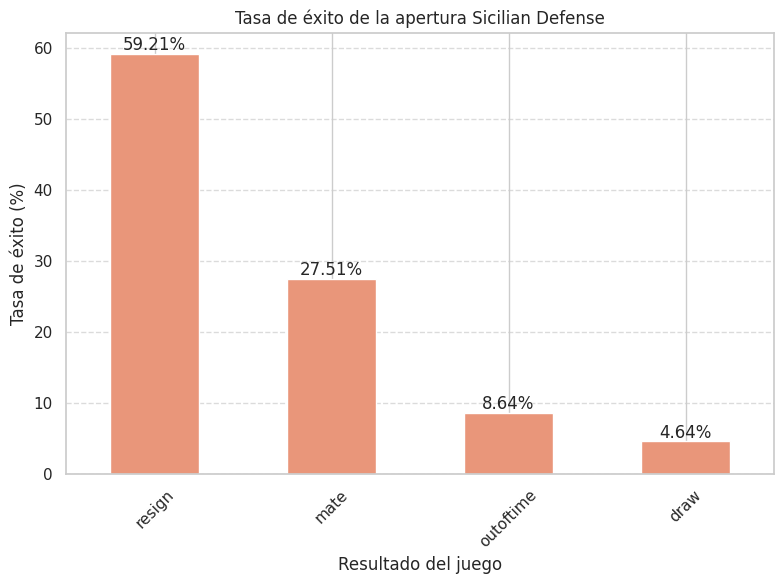

In [38]:
# Calcular la tasa de éxito para cada resultado de juego
success_rate = sicilian_defense.groupby('Resultado').size() / len(sicilian_defense) * 100

# Ordenamos para que las barras se grafiquen de mayor a menor
success_rate_sorted = success_rate.sort_values(ascending=False)

# Graficar la tasa de éxito
plt.figure(figsize=(8, 6))
success_rate_sorted.plot(kind='bar', color='darksalmon')
plt.title('Tasa de éxito de la apertura Sicilian Defense')
plt.xlabel('Resultado del juego')
plt.ylabel('Tasa de éxito (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar la leyenda con los porcentajes
for i, percentage in enumerate(success_rate_sorted):
    plt.text(i, percentage + 0.5, f'{percentage:.2f}%', ha='center')

plt.tight_layout()
plt.show()

Para la defensa siciliana, el porcenjate de partidas terminadas es "resign" es levente mayor y, el porcentaje de empates levemente menor que los porcentajes generales.

Deseamos observar la dsitribución del puntaje en general, pero al visualizarlos en un Boxplot observamos una gran cantidad de outliers del lado derecho, lo que nos conduce a calcular también la mediana para obtener una medida más robusta, no tan influenciada por los valores atípicos.

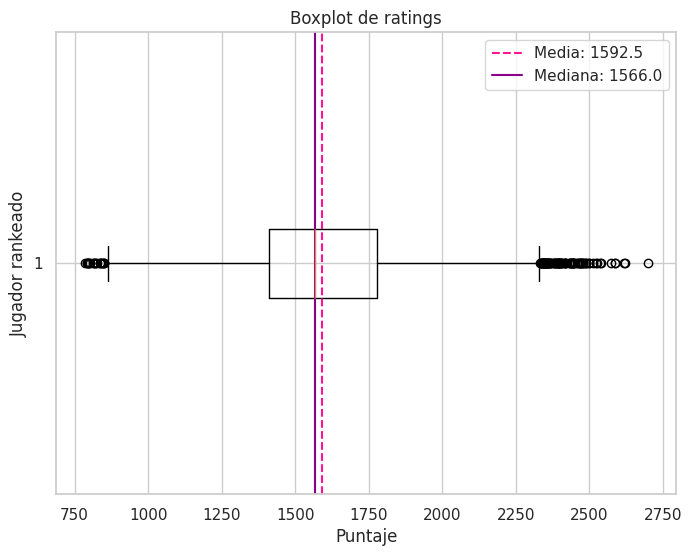

In [39]:
# Creamos un DataFrame auxiliar con los puntajes de cada jugador
df_blancas = pd.DataFrame({
    'ID Jugador': games['ID Blancas'].astype(str),
    'Puntaje': games['Puntaje Blancas']
})
df_negras = pd.DataFrame({
    'ID Jugador': games['ID Negras'].astype(str),
    'Puntaje': games['Puntaje Negras']
})
df_auxiliar = pd.concat([df_blancas, df_negras], ignore_index=True)

# Calculamos el puntaje total de cada jugador
puntajes_por_jugador = df_auxiliar.groupby('ID Jugador')['Puntaje'].mean()

# Creamos el boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(puntajes_por_jugador, vert=False)

# Calculamos la media y la mediana
media = puntajes_por_jugador.mean()
mediana = puntajes_por_jugador.median()

# Agregamos etiquetas y título
plt.title('Boxplot de ratings')
plt.xlabel('Puntaje')
plt.ylabel('Jugador rankeado')

# Agregamos la media y la mediana al gráfico
plt.axvline(x=media, color='deeppink', linestyle='--', label='Media: {:.1f}'.format(media))
plt.axvline(x=mediana, color='darkmagenta', label='Mediana: {:.1f}'.format(mediana))

# Mostramos el gráfico
plt.legend()
plt.show()

Además de la presencia de outliers, notamos que la distribucion es levemente asimetrica a la derecha.

## Correlación

Decidimos graficar una matriz de correlación, con intención de averiguar si había una correlación significativa entre la cantidad de movimientos y el puntaje de los jugadores, entre la cantidad de movimientos y el tiempo de partida (sospechando que a menor tiempo, habría más movimientos para buscar aumentar el tiempo con el incremento por jugada), y entre los puntajes de ambos rivales.

¿Hay relación entre la cantidad de movimientos, y el puntaje de los jugadores? ¿Y entre el puntaje y la elección del tiempo de partida? ¿Si el tiempo de partida es bajo, hay mayor cantidad de movimientos, buscando ganar el incremento por jugada?

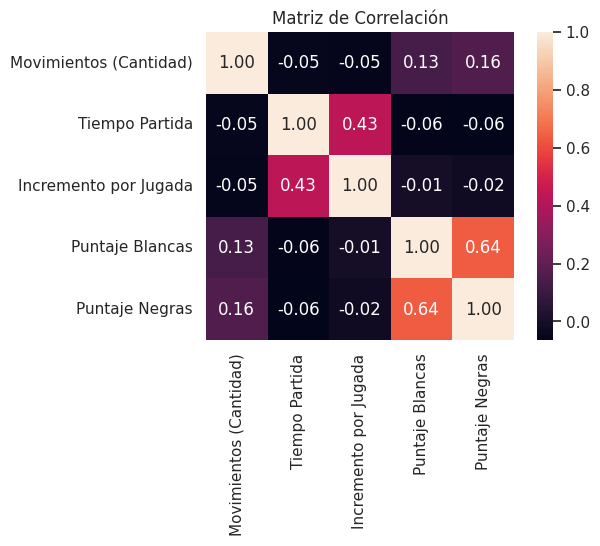

In [40]:
# Graficamos la matriz de correlación
correlation_matrix = games[['Movimientos (Cantidad)', 'Tiempo Partida', 'Incremento por Jugada', 'Puntaje Blancas', 'Puntaje Negras']].corr()

# Utilizamos un mapa de calor (heatmap)
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", square=True)
plt.title('Matriz de Correlación')
plt.show()


Respondiendo las preguntas formuladas, no hay una alta correlación entre la cantidad de movimientos y el puntaje de los jugadores. Tampoco entre el puntaje y la elección del tiempo de partida. Sin embargo, hay que tener en cuenta que estamos evaluando la correlación lineal y puede que haya relaciones de otro tipo.

Si notamos una relacion lineal moderada entre el puntaje de las piezas blancas y el puntaje de las negras. Entonces, deseamos visualizar la relación entre el puntaje de negras y blancas en un scatterplot. ¿Lichess empareja a los jugadores por puntaje?

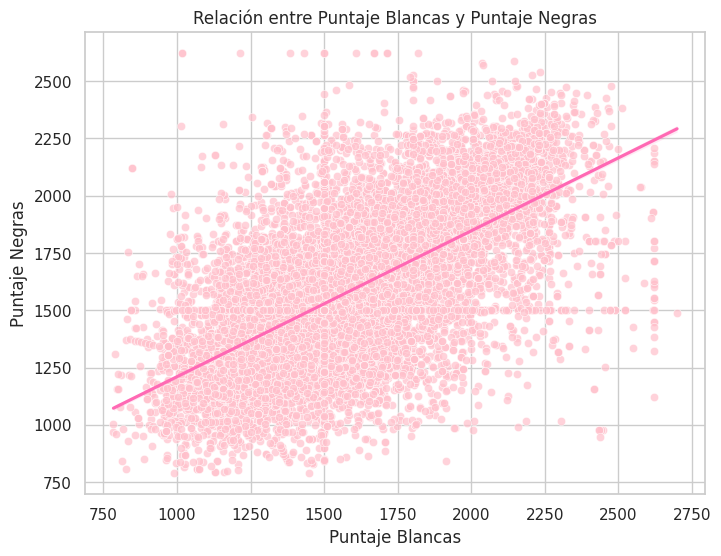

In [41]:
# Graficamos en un scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Puntaje Blancas', y='Puntaje Negras', data=games, color='pink', alpha=0.7)

# Agregamos una línea de regresión lineal y mostrar el coeficiente de correlación
sns.regplot(x='Puntaje Blancas', y='Puntaje Negras', data=games, scatter=False, color='hotpink')

# Mostramos el gráfico
plt.title('Relación entre Puntaje Blancas y Puntaje Negras')
plt.xlabel('Puntaje Blancas')
plt.ylabel('Puntaje Negras')
plt.show()

Observamos que Lichess tiende a emparejar a los jugadores por puntaje.